In [22]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import folium
import numpy as np
from shapely.wkt import loads
from geopy.distance import geodesic
from shapely.geometry import Point, Polygon
from sqlalchemy import create_engine
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd

from pyproj import Geod

geod = Geod(ellps="WGS84")
from shapely.ops import nearest_points
from geopy.distance import geodesic
import mplleaflet
import seaborn as sns
from shapely.wkt import loads

In [23]:
# Função para reconstruir a trajetória
def get_routes(conn):
    query = f"""
    SELECT
        linha,
        week_day,
        ST_AsText(start_point) as start_point,
        ST_AsText(end_point) as end_point,
        ST_AsText(route_line_out) as route_line_out,
        ST_AsText(route_line_back) as route_line_back
    FROM public.bus_routes
    """
    
    # Carregar dados em um GeoDataFrame
    df = pd.read_sql(query, conn)

    return df

# Função trazer os dados de um onibus
def get_bus_data(conn, linha):
    # Selecionar dados da tabela bus_routes para a linha específica
    query = f'''select 
                    *, 
                    ST_Transform(geom::geometry, 4326) AS geometry 
                from vehicle_tracking_filtered where 
                linha = '{linha}'
            '''
        
    # Carregar dados em um GeoDataFrame
    gdf = gpd.read_postgis(query, conn, geom_col='geometry', crs='EPSG:4326')

    return gdf

### Extract Trajectory and Bus_Data

In [24]:

# Conectar ao banco de dados PostgreSQL
conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)



routes = get_routes(conn)
bus_df = get_bus_data(conn, '565')
conn.close()


C:\Users\lucas\AppData\Local\Temp\ipykernel_22992\4038156432.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
c:\Users\lucas\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\io\sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


In [25]:
bus_df  = bus_df.sort_values(by='datahora')
bus_df['datahora'] = pd.to_datetime(bus_df['datahora'])
bus_df['datahoraservidor'] = pd.to_datetime(bus_df['datahoraservidor'])
bus_df['datahoraenvio'] = pd.to_datetime(bus_df['datahoraenvio'])

bus_gdf = gpd.GeoDataFrame(bus_df, geometry='geometry', crs="EPSG:4326")
bus_df.head()

ordem  latitude  longitude  datahora_epoch            datahora  \
6   C30339 -22.99955  -43.35867      1714013647 2024-04-24 23:54:07   
7   C30339 -22.99955  -43.36077      1714013677 2024-04-24 23:54:37   
8   C30339 -22.99804  -43.36471      1714013707 2024-04-24 23:55:07   
9   C30339 -22.99414  -43.36554      1714013736 2024-04-24 23:55:36   
11  C30339 -22.98978  -43.36542      1714013766 2024-04-24 23:56:06   

    velocidade linha  datahoraenvio_epoch  datahoraservidor_epoch  \
6            0   565           1714014301              1714014308   
7           42   565           1714014311              1714014338   
8           57   565           1714014311              1714014338   
9           51   565           1714014311              1714014338   
11          65   565           1714014322              1714014339   

      datahoraservidor       datahoraenvio  \
6  2024-04-25 00:05:08 2024-04-25 00:05:01   
7  2024-04-25 00:05:38 2024-04-25 00:05:11   
8  2024-04-25 00:05:38 2024-04-25 00:05:11   
9  2024-04-25 00:05:38 2024-04-25 00:05:11   
11 2024-04-25 00:05:39 2024-04-25 00:05:22   

                                                 geom  \
6   0101000020E6100000350708E6E8AD45C080B74082E2FF...   
7   0101000020E610000060B01BB62DAE45C080B74082E2FF...   
8   0101000020E6100000184339D1AEAE45C08F19A88C7FFF...   
9   0101000020E61000009FB0C403CAAE45C03CA583F57FFE...   
11  0101000020E6100000F4A62215C6AE45C0213CDA3862FD...   

                       geometry  
6   POINT (-43.35867 -22.99955)  
7   POINT (-43.36077 -22.99955)  
8   POINT (-43.36471 -22.99804)  
9   POINT (-43.36554 -22.99414)  
11  POINT (-43.36542 -22.98978)

In [26]:
routes['route_line_out'] = routes['route_line_out'].map(lambda x: loads(x))
routes['route_line_back'] = routes['route_line_back'].map(lambda x: loads(x))
routes['end_point'] = routes['end_point'].map(lambda x: loads(x))
routes['start_point'] = routes['start_point'].map(lambda x: loads(x))


routes_gdf = gpd.GeoDataFrame(routes, geometry='start_point', crs="EPSG:4326")
routes.head()

linha week_day                                      start_point  \
0     3  Segunda  POINT (-43.495039457092815 -22.883836915499124)   
1   774  Segunda   POINT (-43.32742040832666 -22.807352655457702)   
2   864  Segunda   POINT (-43.46365464290197 -22.876013326220658)   
3   852  Domingo    POINT (-43.64163358974359 -23.00088102564103)   
4   483  Segunda   POINT (-43.28434311311084 -22.836897800432855)   

                                         end_point  \
0   POINT (-43.49507423162255 -22.884352563230294)   
1  POINT (-43.341946615320566 -22.870417119067444)   
2   POINT (-43.55592869637883 -22.901696375116064)   
3   POINT (-43.554660550458706 -22.90174194954129)   
4    POINT (-43.19716470131702 -22.98572288570085)   

                                      route_line_out  \
0  LINESTRING (-43.495039457092815 -22.8838369154...   
1  LINESTRING (-43.32742040832666 -22.80735265545...   
2  LINESTRING (-43.46365464290197 -22.87601332622...   
3  LINESTRING (-43.64163358974359 -23.00088102564...   
4  LINESTRING (-43.28434311311084 -22.83689780043...   

                                     route_line_back  
0  LINESTRING (-43.495039457092815 -22.8838369154...  
1  LINESTRING (-43.341946615320566 -22.8704171190...  
2  LINESTRING (-43.55592869637883 -22.90169637511...  
3  LINESTRING (-43.554660550458706 -22.9017419495...  
4  LINESTRING (-43.19716470131702 -22.98572288570...

### Clean Bus dataset



#### Remove the points that are more than 30 meters from the approximate route


In [27]:
from shapely.geometry import mapping

def remove_far_away_points(linha, routes_df, bus_gdf, datahora_column='datahora'):
    # Select the appropriate route based on the day of the week

    semana = {
        'Segunda': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        'Sabado': ['Saturday'],
        'Domingo': ['Sunday']
    }
    bus_gdf_filtered = pd.DataFrame()
    # bus_gdf_outside_buffer = pd.DataFrame()
    for dia, valores in semana.items():
        bus_gdf_dia = bus_gdf[bus_gdf[datahora_column].dt.day_name().isin(valores)]

        route_row  = routes_df[(routes_df['linha'] == linha) & (routes_df['week_day'] == dia)]

        route_linha_out = route_row['route_line_out'].values[0]
        route_linha_back = route_row['route_line_back'].values[0]
        start_point = route_row['start_point'].values[0]
        end_point = route_row['end_point'].values[0]
        
        # Create GeoDataFrames for the routes and reproject to a metric CRS
        gdf_out = gpd.GeoDataFrame(geometry=[route_linha_out], crs="EPSG:4326").to_crs(epsg=3857)
        gdf_back = gpd.GeoDataFrame(geometry=[route_linha_back], crs="EPSG:4326").to_crs(epsg=3857)
        gdf_start = gpd.GeoDataFrame(geometry=[start_point], crs="EPSG:4326").to_crs(epsg=3857)
        gdf_end = gpd.GeoDataFrame(geometry=[end_point], crs="EPSG:4326").to_crs(epsg=3857)
        
        
        
        # Reproject bus_gdf to metric CRS for spatial operations
        bus_gdf_metric = bus_gdf_dia.to_crs(epsg=3857)
        
        # Filter bus_gdf to remove points further than 30 meters from both route lines
        within_route_buffer = bus_gdf_metric.geometry.within(gdf_out.geometry.buffer(30).unary_union) | bus_gdf_metric.geometry.within(gdf_back.geometry.buffer(30).unary_union)
        
        # Filter bus_gdf to include points within 200 meters of start or end points
        within_points_buffer = bus_gdf_metric.geometry.within(gdf_start.geometry.buffer(200).unary_union) | bus_gdf_metric.geometry.within(gdf_end.geometry.buffer(200).unary_union)
        
        # Combine both conditions
        bus_gdf_filtered = pd.concat([bus_gdf_filtered, bus_gdf_metric[within_route_buffer | within_points_buffer].to_crs(epsg=4326)])

    return bus_gdf_filtered

In [28]:
bus_gdf_filtered = remove_far_away_points('565', routes, bus_gdf)

In [29]:
bus_gdf_filtered.shape, bus_gdf.shape

((1099088, 13), (1238611, 13))

- With this filter we removed 27% of the data

##### Example

In [30]:
bus_gdf_terca = bus_gdf_filtered[bus_gdf_filtered['datahora'].dt.day_of_week == 3]
route_row  = routes_gdf[(routes_gdf['linha'] == '565') & (routes_gdf['week_day'] == 'Segunda')]

route_linha_out = route_row['route_line_out'].values[0]
route_linha_back = route_row['route_line_back'].values[0]
route_linha_out = route_row['route_line_out'].values[0]
route_linha_back = route_row['route_line_back'].values[0]
start_point = route_row['start_point'].values[0]
end_point = route_row['end_point'].values[0]


# Create GeoDataFrames for the routes and reproject to a metric CRS
gdf_out = gpd.GeoDataFrame(geometry=[route_linha_out], crs="EPSG:4326").to_crs(epsg=3857)
gdf_back = gpd.GeoDataFrame(geometry=[route_linha_back], crs="EPSG:4326").to_crs(epsg=3857)
gdf_start = gpd.GeoDataFrame(geometry=[start_point], crs="EPSG:4326").to_crs(epsg=3857)
gdf_end = gpd.GeoDataFrame(geometry=[end_point], crs="EPSG:4326").to_crs(epsg=3857)

# Buffer route lines by 30 meters
route_linha_out_buffer = gdf_out.geometry.buffer(30).to_crs(epsg=4326)
route_linha_back_buffer = gdf_back.geometry.buffer(30).to_crs(epsg=4326)

# Buffer start and end points by 200 meters
start_point_buffer = gdf_start.geometry.buffer(200).to_crs(epsg=4326)
end_point_buffer = gdf_end.geometry.buffer(200).to_crs(epsg=4326)
    


In [31]:

m = folium.Map(location=[bus_gdf_filtered['geometry'].y.mean(), bus_gdf_filtered['geometry'].x.mean()], zoom_start=14)


# Plot the route lines
# folium.PolyLine(locations=[(point[1], point[0]) for point in route_linha_out.coords], color='blue', weight=2.5, opacity=1).add_to(m)
# folium.PolyLine(locations=[(point[1], point[0]) for point in route_linha_back.coords], color='blue', weight=2.5, opacity=1).add_to(m)

# Add the buffer zones to the map
out_buffer_coords = mapping(route_linha_out_buffer[0])['coordinates'][0]
back_buffer_coords = mapping(route_linha_back_buffer[0])['coordinates'][0]

# Plot the route lines
folium.Polygon(locations=[(coord[1], coord[0]) for coord in out_buffer_coords], color='blue', fill=True, fill_opacity=0.3).add_to(m)
folium.Polygon(locations=[(coord[1], coord[0]) for coord in back_buffer_coords], color='blue', fill=True, fill_opacity=0.3).add_to(m)

# Add the start and end point buffers to the map
start_buffer_coords = mapping(start_point_buffer[0])['coordinates'][0]
end_buffer_coords = mapping(end_point_buffer[0])['coordinates'][0]

folium.Polygon(locations=[(coord[1], coord[0]) for coord in start_buffer_coords], color='green', fill=True, fill_opacity=0.3).add_to(m)
folium.Polygon(locations=[(coord[1], coord[0]) for coord in end_buffer_coords], color='purple', fill=True, fill_opacity=0.3).add_to(m)



# Add the bus points outside the buffer zones to the map
for _, row in bus_gdf_terca.sample(5000).iterrows():
    folium.Circle(location=(row['geometry'].y, row['geometry'].x), popup=row['ordem'], color='red', radius=3).add_to(m)

In [32]:
m

#### Remove buses with a time too far from the server time

In [33]:
def remove_time_outliers(bus_gdf):
    # Convert to datetime
    bus_gdf['datahora'] = pd.to_datetime(bus_gdf['datahora'])
    bus_gdf['datahoraservidor'] = pd.to_datetime(bus_gdf['datahoraservidor'])
    
    # Calculate the time difference in seconds
    bus_gdf['time_diff'] = (bus_gdf['datahoraservidor'] - bus_gdf['datahora']).dt.total_seconds()
    
    # Calculate mean and standard deviation
    mean_diff = bus_gdf['time_diff'].mean()
    std_diff = bus_gdf['time_diff'].std()
    
    # Filter out the outliers
    filtered_gdf = bus_gdf[(bus_gdf['time_diff'] >= (mean_diff - 3 * std_diff)) & (bus_gdf['time_diff'] <= (mean_diff + 3 * std_diff))]
    
    return filtered_gdf

In [34]:
new_bus_gdf = remove_time_outliers(bus_gdf_filtered)

In [35]:
new_bus_gdf.shape, bus_gdf_filtered.shape

((1083214, 14), (1099088, 14))

- With this filter we removed 1% of the remained data

### Create function to calculate and normaliza ditances along trajectory line

In [36]:
from shapely.ops import nearest_points
from shapely.ops import split

def project_point_to_line(point, line, start, end):
    """Projetar um ponto na linha."""
    if point.within(start):
        return Point(line.coords[0])

    if point.within(end):   
        return Point(line.coords[-1])
    
    point_on_line = line.interpolate(line.project(point))
    return point_on_line


def insert_point_in_linestring(line, point):
    coords = list(line.coords)
    for i in range(len(coords) - 1):
        segment = LineString([coords[i], coords[i + 1]])
        if  point.distance(segment) < 1e-9:
            return LineString(coords[:i + 1] + [(point.x, point.y)] + coords[i + 1:])
    return line


def calculate_distance_along_line(line, point1, start, end):
    # Projetando os pontos na linha para encontrar A e B
    if point1.within(start):
        return 0

    if point1.within(end):   
        return geod.geometry_length(line)


    proj_point1 = project_point_to_line(point1, line, start, end)
    # proj_point2 = project_point_to_line(point2, line)

    line_c = insert_point_in_linestring(line, proj_point1)
    # line_c = insert_point_in_linestring(line_c, proj_point2)
   

    # Criando LineStrings parciais
    split_line1 = split(line_c, proj_point1)
    # split_line2 = split(line_c, proj_point2)

    # distance_along_line = geod.geometry_length(split_line2.geoms[1]) - geod.geometry_length(split_line1.geoms[1])
    return geod.geometry_length(split_line1.geoms[0])

In [37]:
def start_end_buffered(routes_df, linha):
    route_row = routes_df.loc[routes_gdf['linha'] == linha]
    start_point = route_row['start_point'].values[0]
    end_point = route_row['end_point'].values[0]
    gdf_start = gpd.GeoDataFrame(geometry=[start_point], crs="EPSG:4326").to_crs(epsg=3857)
    gdf_end = gpd.GeoDataFrame(geometry=[end_point], crs="EPSG:4326").to_crs(epsg=3857)
    start_point_buffer = gdf_start.geometry.buffer(200).to_crs(epsg=4326)
    end_point_buffer = gdf_end.geometry.buffer(200).to_crs(epsg=4326)
    return start_point_buffer[0], end_point_buffer[0]
        

##### Example

In [38]:
bus_sample = new_bus_gdf[new_bus_gdf['ordem'] == 'B25592'].sort_values('datahora')
# point1 = bus_sample.iloc[0]['geometry']
point1 = bus_sample.iloc[5]['geometry']




rota_volta = routes_gdf.loc[routes_gdf['linha'] == '565', 'route_line_back'].iloc[0]

start, end = start_end_buffered(routes_gdf, '565')


proj_point1_volta = project_point_to_line(point1, rota_volta, end, start)
rota_volta_c = insert_point_in_linestring(rota_volta, proj_point1_volta)

# Criando LineStrings parciais
split_line_volta = split(rota_volta_c, proj_point1_volta)

geod.geometry_length(split_line_volta.geoms[0])


IndexError: single positional indexer is out-of-bounds

In [39]:

m = folium.Map(location=[new_bus_gdf['geometry'].y.mean(), new_bus_gdf['geometry'].x.mean()], zoom_start=14)


# Plot the route lines
folium.PolyLine(locations=[(point[1], point[0]) for point in route_linha_out.coords], color='blue', weight=2.5, opacity=1).add_to(m)
folium.PolyLine(locations=[(point[1], point[0]) for point in route_linha_back.coords], color='blue', weight=2.5, opacity=1).add_to(m)


folium.Circle(location=(point1.y, point1.x), popup='point1', color='red', radius=3).add_to(m)

# folium.Circle(location=(point2.y, point2.x), popup='point2', color='red', radius=20).add_to(m)

# folium.Circle(location=(proj_point1_ida.y, proj_point1_ida.x), popup='proj_point_ida', color='green', radius=3).add_to(m)
folium.Circle(location=(proj_point1_volta.y, proj_point1_volta.x), popup='proj_point_volta', color='green', radius=3).add_to(m)

# # Plot the route lines to segments
folium.PolyLine(locations=[(point[1], point[0]) for point in split_line_volta.geoms[0].coords], color='yellow', weight=5, opacity=1).add_to(m)
# folium.PolyLine(locations=[(point[1], point[0]) for point in split_line_ida.geoms[0].coords], color='purple', weight=4.5, opacity=1).add_to(m)





NameError: name 'point1' is not defined

In [ ]:
m

#### Calculate percurso 

In [40]:
def calculate_precise_distance_point_to_line(point, line):
    nearest_pt = nearest_points(point, line)[1]
    return geodesic((point.y, point.x), (nearest_pt.y, nearest_pt.x)).meters

In [41]:
def calculate_percurso(point1, point2, route_line_out, route_line_back, start, end):
    # Calcular as distâncias ao longo da linha
    dist_i1_out = calculate_distance_along_line(route_line_out, point1, start, end)
    dist_i2_out = calculate_distance_along_line(route_line_out, point2, start, end)

    # Calcular as distâncias ao longo da linha
    dist_i1_back = calculate_distance_along_line( route_line_back, point1, end, start)
    dist_i2_back = calculate_distance_along_line( route_line_back, point2, end, start)

    dist_proj_out =  calculate_precise_distance_point_to_line(point2, route_line_out)
    dist_proj_back = calculate_precise_distance_point_to_line(point2, route_line_back)

    if point2.within(start): 
        return 'ponto_inicial'
    elif point2.within(end): 
        return 'ponto_final'
    elif dist_proj_out - dist_proj_back > 20:
        if dist_proj_out > dist_proj_back:
            return 'volta'
        else:
            return 'ida'
    elif point1.distance(point2) < 10**(-5):
        return 'sem_movimento'
    else:
        if dist_i1_out < dist_i2_out: 
            return 'ida'
        elif dist_i1_back < dist_i2_back:
            return 'volta'
    
        
    return 'sem_movimento'


In [42]:
start, end = start_end_buffered(routes_gdf, '565')

bus_sample = new_bus_gdf[new_bus_gdf['ordem'] == 'B25607'].sort_values('datahora').reset_index(drop=True)

point1 = bus_sample.iloc[25]['geometry']
point2 = bus_sample.iloc[26]['geometry']
rota_volta = routes_gdf.loc[routes_gdf['linha'] == '565', 'route_line_back'].iloc[0]
rota_ida = routes_gdf.loc[routes_gdf['linha'] == '565', 'route_line_out'].iloc[0]


IndexError: single positional indexer is out-of-bounds

In [ ]:
calculate_percurso(point1, point2, rota_ida, rota_volta, start, end)

'volta'

In [ ]:

m = folium.Map(location=[point1.y, point1.x], zoom_start=14)


# Plot the route lines
folium.PolyLine(locations=[(point[1], point[0]) for point in route_linha_out.coords], color='blue', weight=2.5, opacity=1).add_to(m)
folium.PolyLine(locations=[(point[1], point[0]) for point in route_linha_back.coords], color='green', weight=2.5, opacity=1).add_to(m)


folium.Circle(location=(point1.y, point1.x), popup='point1', color='red', radius=3).add_to(m)
folium.Circle(location=(point2.y, point2.x), popup='point2', color='red', radius=3).add_to(m)
m


### Calculate Mean Speed

In [43]:
def calculate_bus_routes(row, route_line_out, route_linha_back, start, end):
    if row.name == 0:
        return None
    else:
        percurso = calculate_percurso(row['geometry_before'], row['geometry_actual'], route_line_out, route_linha_back, start, end)
        return percurso
    
# Função para remover outliers com base na IQR
def remove_outliers_from_bus(df, column, factor=2.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def calculate_bus_distance(row, route_line_out, route_linha_back, start, end):
    if row['route'] == 'ida':
        return calculate_distance_along_line(route_line_out, row['geometry_actual'],  start, end)
    elif row['route'] == 'volta':
        return calculate_distance_along_line(route_linha_back,  row['geometry_actual'], end, start)
    elif  row['route'] == 'ponto_inicial' or row['route'] == 'ponto_final':
        return 0
    return 0


In [44]:
import warnings
warnings.filterwarnings('ignore')
def generate_vel_model(day_of_week, hora, routes_gdf, bus_gdf, linha):
    ordens = bus_gdf['ordem'].unique()
    cat_horas = {
        'rush_manha': [8, 9, 10, 11],
        'tarde': [12, 13, 14, 15],
        'rush_noite': [16, 17, 18, 19],
        'noite': [20, 21, 22, 23]
    }
    semana = {
        'Monday': 'Segunda',
        'Tuesday': 'Segunda',
        'Wednesday': 'Segunda',
        'Thursday': 'Segunda',
        'Friday': 'Segunda',
        'Saturday': 'Sabado',
        'Sunday': 'Domingo'
    }
    rota_volta = routes_gdf.loc[(routes_gdf['linha'] == linha) & (routes_gdf['week_day'] == semana[day_of_week]), 'route_line_back'].values[0]
    rota_ida = routes_gdf.loc[(routes_gdf['linha'] == linha) & (routes_gdf['week_day'] == semana[day_of_week]), 'route_line_out'].values[0]
    start, end = start_end_buffered(routes_gdf, linha)
    bus_line_vel = pd.DataFrame()
    for ord in ordens:
        print('Processing', ord)
        bus_sample = bus_gdf[
            (bus_gdf['ordem'] == ord) & 
            (bus_gdf['datahora'].dt.day_name() == day_of_week) &
            (bus_gdf['datahora'].dt.hour.isin(cat_horas[hora]))
        ].sort_values('datahora').reset_index(drop=True)
        if bus_sample.shape[0] < 4:
            continue

        before = bus_sample.loc[:, ['ordem', 'datahora', 'linha', 'geometry']].shift(1)
        actual = bus_sample.loc[:, ['ordem', 'datahora', 'linha', 'geometry']]

        before.columns = [f'{c}_before' for c in before.columns]
        actual.columns = [f'{c}_actual' for c in actual.columns]

        bus_samples_concat = pd.concat([actual, before], axis=1)
  
        ## Remove outliers
        bus_samples_concat['datahora_actual'] = pd.to_datetime(bus_samples_concat['datahora_actual'])
        bus_samples_concat['datahora_before'] = pd.to_datetime(bus_samples_concat['datahora_before'])
 
        # Calcular a diferença de tempo em segundos
        bus_samples_concat['time_diff'] = (bus_samples_concat['datahora_actual'] - bus_samples_concat['datahora_before']).dt.total_seconds()
        # Calcular a diferença de distância em metros
        bus_samples_concat['distance_diff'] = bus_samples_concat.apply(lambda row: row['geometry_actual'].distance(row['geometry_before']), axis=1)

        # Remover outliers com base na diferença de tempo
        bus_samples_concat = remove_outliers_from_bus(bus_samples_concat, 'time_diff', factor=1.5)
        # Remover outliers com base na diferença de distância
        bus_samples_concat = remove_outliers_from_bus(bus_samples_concat, 'distance_diff', factor=1.5)

        bus_samples_concat = bus_samples_concat.reset_index()

        bus_samples_concat['route'] = bus_samples_concat.apply(lambda row: calculate_bus_routes(row, rota_ida, rota_volta, start, end), axis=1)
        bus_samples_concat['route'] = bus_samples_concat['route'].replace("sem_movimento", pd.NA)
        bus_samples_concat['route']  = bus_samples_concat['route'].fillna(method='ffill').fillna(method='bfill')

        bus_samples_concat['rel_pos'] =  bus_samples_concat.apply(lambda row: calculate_bus_distance(row, rota_ida, rota_volta, start, end), axis=1)

        bus_samples_concat['pos_diff'] = bus_samples_concat.groupby('route')['rel_pos'].diff()
        bus_samples_concat['time_diff'] = bus_samples_concat.groupby('route')['datahora_actual'].diff().dt.total_seconds() / 60  # Converter tempo minutos
        # Calcular a velocidade
        bus_samples_concat['velocidade'] = bus_samples_concat['pos_diff'] / bus_samples_concat['time_diff']


        # Remover as linhas onde a velocidade não pode ser calculada (primeiros elementos de cada grupo)
        bus_samples_concat = bus_samples_concat.dropna(subset=['velocidade'])

        bus_samples_concat = bus_samples_concat[bus_samples_concat['velocidade'] > 0]


        bus_line_vel = pd.concat([bus_line_vel, bus_samples_concat])
    
    return bus_line_vel

In [45]:
from scipy.interpolate import interp1d

def interpolate_data(x, y, new_x):
    f = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
    return f(new_x)

# Função para calcular a média móvel
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def interpolate_mean_route(bus_line_vel):
    combined_df_ida = pd.DataFrame()
    combined_df_volta = pd.DataFrame()
    ordens = bus_line_vel['ordem_actual'].unique()
    max_rel_ida = bus_line_vel.loc[bus_line_vel['route'] == 'ida', 'rel_pos'].max()
    max_rel_volta = bus_line_vel.loc[bus_line_vel['route'] == 'volta', 'rel_pos'].max()
    min_rel_ida = bus_line_vel.loc[bus_line_vel['route'] == 'ida', 'rel_pos'].min()
    min_rel_volta = bus_line_vel.loc[bus_line_vel['route'] == 'volta', 'rel_pos'].min()
    window_size = 10
    num_ida = max_rel_ida/20
    num_volta = max_rel_volta/20

    common_rel_pos_ida = np.linspace(min_rel_ida, max_rel_ida, round(num_ida))
    common_rel_pos_volta = np.linspace(min_rel_volta, max_rel_volta, round(num_volta))

    for ord in ordens:
        df_ida = bus_line_vel[
            (bus_line_vel['ordem_actual'] == ord) &
            (bus_line_vel['route'] == 'ida')
        ].sort_values(by='rel_pos')

        df_volta = bus_line_vel[
            (bus_line_vel['ordem_actual'] == ord) &
            (bus_line_vel['route'] == 'volta')
        ].sort_values(by='rel_pos')

        if df_ida.shape[0] != 0:
            interpolated_out1 = interpolate_data(df_ida['rel_pos'], df_ida['velocidade'], common_rel_pos_ida)
            ma_interpolated_out1 = moving_average(interpolated_out1, window_size)
           

            interpolated_df_ida = pd.DataFrame({
                'rel_pos': common_rel_pos_ida[:len(ma_interpolated_out1)],
                'speed': ma_interpolated_out1
            })
            combined_df_ida = pd.concat([combined_df_ida, interpolated_df_ida], ignore_index=True)
        
        if df_volta.shape[0] != 0:
            interpolated_out2 = interpolate_data(df_volta['rel_pos'], df_volta['velocidade'], common_rel_pos_volta)
            ma_interpolated_out2 = moving_average(interpolated_out2, window_size)
            interpolated_df_volta = pd.DataFrame({
                'rel_pos': common_rel_pos_volta[:len(ma_interpolated_out2)],
                'speed': ma_interpolated_out2
            })
            combined_df_volta = pd.concat([combined_df_volta, interpolated_df_volta], ignore_index=True)
            
    mean_df_ida = combined_df_ida.groupby('rel_pos').mean().reset_index()
    mean_df_volta = combined_df_volta.groupby('rel_pos').mean().reset_index()
    return mean_df_ida, mean_df_volta

In [46]:
from scipy.integrate import quad
from scipy.integrate import cumtrapz

def tempo_para_distancia(distancia, interp_func):
    def integrand(d):
        return 1 / interp_func(d)
    tempo_total, _ = quad(integrand, 0, distancia)
    return tempo_total

#### Example

In [48]:
day = 'Monday'
hour = 'noite'

bus_vel = generate_vel_model(day, hour, routes_gdf, new_bus_gdf, '565')

Processing C30339
Processing C30224
Processing C30197
Processing C30344
Processing C30060
Processing C30311
Processing C30220
Processing C30071
Processing C30346
Processing C30221
Processing C30223
Processing C30188
Processing C30370
Processing C30348
Processing C30336
Processing C30180
Processing C30183
Processing C30186
Processing C30192
Processing C30338
Processing C30335
Processing C30024
Processing C30343
Processing C30194
Processing C30079
Processing C30014
Processing C30187
Processing C30048
Processing C30184
Processing C30007
Processing C30337
Processing C30353
Processing C30020
Processing C30003
Processing C30342
Processing C30376
Processing C30135
Processing C30027
Processing C30332
Processing C30127
Processing C30193
Processing C30190
Processing C30016
Processing C30162
Processing C30297
Processing C30222
Processing C30333
Processing C30189
Processing C30274
Processing C30158
Processing C30263
Processing C30179
Processing C30345
Processing C30034
Processing C30136
Processing

In [ ]:
mean_df_ida, mean_df_volta = interpolate_mean_route(bus_vel)

In [ ]:
interp_func_ida_rel = interp1d(mean_df_ida['rel_pos'], mean_df_ida['speed'], kind='linear', fill_value='extrapolate')
times_ida = cumtrapz(1 / interp_func_ida_rel.y, interp_func_ida_rel.x, initial=0)
interp_func_ida_time = interp1d(times_ida, interp_func_ida_rel.y, kind='linear', fill_value='extrapolate')



interp_func_volta_rel = interp1d(mean_df_volta['rel_pos'], mean_df_volta['speed'], kind='linear', fill_value='extrapolate')
times_volta = cumtrapz(1 / interp_func_volta_rel.y, interp_func_volta_rel.x, initial=0)
interp_func_volta_time = interp1d(times_volta, interp_func_volta_rel.y, kind='linear', fill_value='extrapolate')



Text(0, 0.5, 'Speed (meters/minutes)')

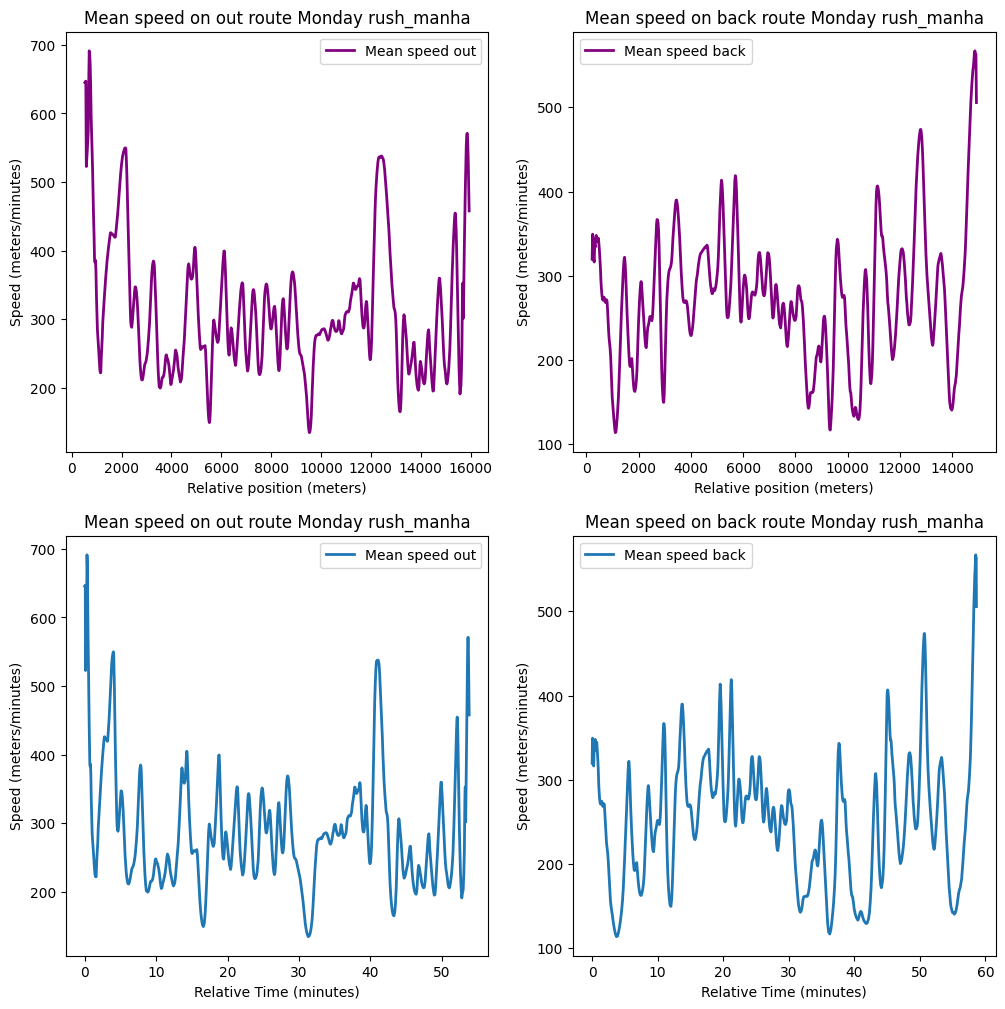

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plotando os gráficos nas subplots
axs[0, 0].set_title(f'Mean speed on out route {day} {hour}')
sns.lineplot(x=interp_func_ida_rel.x, y=interp_func_ida_rel.y, label='Mean speed out', linewidth=2, ax=axs[0, 0], color='purple')
axs[0, 0].set_xlabel('Relative position (meters)')
axs[0, 0].set_ylabel('Speed (meters/minutes)')

axs[0, 1].set_title(f'Mean speed on back route {day} {hour}')
sns.lineplot(x=interp_func_volta_rel.x, y=interp_func_volta_rel.y, label='Mean speed back', linewidth=2, ax=axs[0, 1], color='purple')
axs[0, 1].set_xlabel('Relative position (meters)')
axs[0, 1].set_ylabel('Speed (meters/minutes)')

axs[1, 0].set_title(f'Mean speed on out route {day} {hour}')
sns.lineplot(x=interp_func_ida_time.x, y=interp_func_ida_time.y, label='Mean speed out', linewidth=2, ax=axs[1, 0])
axs[1, 0].set_xlabel('Relative Time (minutes)')
axs[1, 0].set_ylabel('Speed (meters/minutes)')

axs[1, 1].set_title(f'Mean speed on back route {day} {hour}')
sns.lineplot(x=interp_func_volta_time.x, y=interp_func_volta_time.y, label='Mean speed back', linewidth=2, ax=axs[1, 1])
axs[1, 1].set_xlabel('Relative Time (minutes)')
axs[1, 1].set_ylabel('Speed (meters/minutes)')
